# Anomaly Detection in Photovoltaic Power Time-Series using Deep Learning

This notebook implements the methodology described in the paper:  
**_"Data anomaly detection in photovoltaic power time-series via unsupervised deep learning with insufficient information"_** (2023)  
by Sun, S., Jia, Y., Fan, Y., Liu, Y., Zhang, C., & Li, J. – published in *Energy Reports*. [[Link to paper](https://www.sciencedirect.com/science/article/pii/S2352467725001511)]

---

### Objective

The goal is to replicate and validate the core workflow proposed in the paper, with a focus on:

- Constructing daily time-series samples of photovoltaic (PV) power data
- Handling missing or noisy measurements
- Applying min-max normalization
- Training a deep autoencoder on unlabeled data to learn data representations
- Detecting anomalies based on reconstruction error thresholds
- Using Dynamic Time Warping (DTW) for localizing anomalous segments

---

In [1]:
# 1. Install Dependencies and Import Libraries
!pip install tensorflow scikit-learn dtw-python matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from google.colab import files # Import the files module

In [2]:
# 2. Upload CSV files
uploaded = files.upload()
filenames = list(uploaded.keys())
print('Uploaded files:', filenames)

Saving Plant_2_Generation_Data.csv to Plant_2_Generation_Data (1).csv
Saving Plant_1_Generation_Data.csv to Plant_1_Generation_Data (1).csv
Uploaded files: ['Plant_2_Generation_Data (1).csv', 'Plant_1_Generation_Data (1).csv']


**Exploratory Data Analysis (EDA)**

In [3]:
# 3. Exploratory Data Analysis (EDA)
gen_files = [f for f in filenames if 'Generation' in f]
for fn in gen_files:
    df = pd.read_csv(fn)
    print(f"\n=== {fn} ===")
    print("Total rows:", len(df))
    print("Columns:", df.columns.tolist())
    inv_col = None
    for c in ['SOURCE_KEY']:
        if c in df.columns:
            inv_col = c
            break
    if inv_col:
        print("Unique inverters:", df[inv_col].nunique())
    print("Missing % per column:\n", (df.isna().mean()*100))


=== Plant_2_Generation_Data (1).csv ===
Total rows: 67698
Columns: ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
Unique inverters: 22
Missing % per column:
 DATE_TIME      0.0
PLANT_ID       0.0
SOURCE_KEY     0.0
DC_POWER       0.0
AC_POWER       0.0
DAILY_YIELD    0.0
TOTAL_YIELD    0.0
dtype: float64

=== Plant_1_Generation_Data (1).csv ===
Total rows: 68778
Columns: ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
Unique inverters: 22
Missing % per column:
 DATE_TIME      0.0
PLANT_ID       0.0
SOURCE_KEY     0.0
DC_POWER       0.0
AC_POWER       0.0
DAILY_YIELD    0.0
TOTAL_YIELD    0.0
dtype: float64


In [4]:
# 4. Merge generation CSVs into an (m×44)×96 matrix with NaNs for missing slots
#1) Read & concatenate all generation CSVs
dfs = []
for fn in gen_files:
    df = pd.read_csv(
        fn,
        parse_dates=['DATE_TIME']   # parse into datetime
    )
    # standardize inverter column
    if 'SOURCE_KEY' in df.columns:
        df.rename(columns={'SOURCE_KEY':'inverter'}, inplace=True)
    else:
        df['inverter'] = fn
    # keep only what we need
    dfs.append(df[['DATE_TIME','inverter','AC_POWER']])

df_all = pd.concat(dfs, ignore_index=True)

# 2) Derive 'date' and 'slot' indices
df_all['date'] = df_all['DATE_TIME'].dt.date
df_all['slot'] = (df_all['DATE_TIME'].dt.hour * 4 +
                  df_all['DATE_TIME'].dt.minute // 15)

# 3) Build a full MultiIndex of every (date, inverter, slot)
dates = sorted(df_all['date'].unique())
inverters = sorted(df_all['inverter'].unique())
slots = list(range(96))  # 0 through 95
full_index = pd.MultiIndex.from_product(
    [dates, inverters, slots],
    names=['date','inverter','slot']
)

# 4) Reindex the AC_POWER series onto the full grid
ser = df_all.set_index(['date','inverter','slot'])['AC_POWER']
ser_full = ser.reindex(full_index)

# 5) Pivot to create the wide matrix X of shape ((m*44), 96)
''' 44 inverters,
34 days,
96 time-slots per day,
m = 44×34 = 1,496
n = 96'''
mat = ser_full.unstack(level='slot')  # rows = (date,inverter), cols = slots 0–95
X = mat.values                         # a NumPy array with NaNs where data was missing

print("Resulting matrix X shape:", X.shape)  # should be (m*44, 96)


/tmp/ipython-input-3934323280.py:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


Resulting matrix X shape: (1496, 96)


In [5]:
# Matrix format
mat.head()

slot                         0    1    2    3    4    5    6    7    8    9   \
date       inverter                                                            
2020-05-15 1BY6WEcLGh8j5v7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
           1IF53ai7Xc0U56Y  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
           3PZuoBAID5Wc2HD  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
           4UPUqMRk7TRMgml  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
           7JYdWkrLSPkdwr4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

slot                        ...   86   87   88   89   90   91   92  93   94  \
date       inverter         ...                                               
2020-05-15 1BY6WEcLGh8j5v7  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 NaN  NaN   
           1IF53ai7Xc0U56Y  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 NaN  NaN   
           3PZuoBAID5Wc2HD  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 NaN  NaN   
           4UPUqMRk7TRMgml  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 NaN  0.0   
           7JYdWkrLSPkdwr4  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 NaN  NaN   

slot                         95  
date       inverter              
2020-05-15 1BY6WEcLGh8j5v7  NaN  
           1IF53ai7Xc0U56Y  NaN  
           3PZuoBAID5Wc2HD  NaN  
           4UPUqMRk7TRMgml  0.0  
           7JYdWkrLSPkdwr4  NaN  

[5 rows x 96 columns]

In [6]:
# Inspect missing timestamps in the merged (m×44)×96 matrix

df_full = mat.copy()  # shape = (m*44, 96)

# Count missing slots per inverter-day
missing_per_row = df_full.isna().sum(axis=1)
# Total count of missing slots
print("Total missing slots:", missing_per_row.sum())
# Count missing slots per inverter
missing_summary = missing_per_row[missing_per_row > 0].sort_values(ascending=False)
print("Inverter-days with missing slots (count):")
display(missing_summary.to_frame(name='missing_slots'))


Total missing slots: 7140
Inverter-days with missing slots (count):


missing_slots
date       inverter                      
2020-05-25 xMbIugepa2P7lBB             96
2020-05-26 xMbIugepa2P7lBB             96
2020-05-23 IQ2d7wF4YD8zU1Q             96
2020-05-22 xMbIugepa2P7lBB             96
           NgDl19wMapZy17u             96
...                                   ...
2020-05-15 Qf4GUc1pJu5T6c6              1
           PeE6FRyGXUgsRhN              1
           NgDl19wMapZy17u              1
           Mx2yZCDsyf6DPfv              1
           LlT2YUhhzqhg5Sw              1

[470 rows x 1 columns]

In [7]:
# 5. Preprocess: resample, drop/gap fill
# 1) Record initial stats
initial_rows = df_full.shape[0]
initial_missing = df_full.isna().sum().sum()

# prepare lists
dropped = []
filled = []

# make a copy to process
df_processed = df_full.copy()

# 2) Drop or fill each inverter-day
for idx, row in df_full.iterrows():
    # mask of NaNs
    is_na = row.isna()
    # lengths of consecutive NaNs
    runs = is_na.astype(int).groupby((~is_na).cumsum()).sum()
    max_consec = int(runs.max()) if not runs.empty else 0

    if max_consec > 10:
        # drop this row
        dropped.append((idx[0], idx[1], max_consec)) # Store date, inverter, and max_consec for dropped
    else:
        # linear interpolate interior gaps
        filled_row = row.interpolate(method='linear', limit_direction='both')
        # fill edges
        filled_row = filled_row.ffill().bfill()
        df_processed.loc[idx] = filled_row
        filled.append(idx)

# actually drop the flagged rows
df_processed = df_processed.drop(index=[d[0] for d in dropped]) # Drop using original index (date, inverter)

# 3) Record post-processing stats
rows_after = df_processed.shape[0]
missing_after_drop = df_full.drop(index=[d[0] for d in dropped]).isna().sum().sum() # Calculate missing after dropping
missing_after_fill = df_processed.isna().sum().sum()

# 4) Print report
print(f"Initial rows:           {initial_rows}")
print(f"Rows dropped:           {len(dropped)}")
print(f"Rows remaining:         {rows_after}")
print(f"Initial missing cells:  {initial_missing}")
print(f"Missing after drop:     {missing_after_drop}")
print(f"Missing after fill:     {missing_after_fill}")

# 5) create DataFrames of dropped/filled
df_dropped = pd.DataFrame(dropped, columns=['date', 'inverter', 'max_consec_nan']) # Create DataFrame directly from list of tuples
df_filled = pd.DataFrame(filled, columns=['date', 'inverter']) # Create DataFrame directly from list of tuples

print("\nDropped inverter-days:")
display(df_dropped)
print("\nFilled inverter-days:")
display(df_filled)

Initial rows:           1496
Rows dropped:           116
Rows remaining:         1012
Initial missing cells:  7140
Missing after drop:     646
Missing after fill:     0

Dropped inverter-days:


,date,inverter,max_consec_nan
0,2020-05-19,1IF53ai7Xc0U56Y,14
1,2020-05-19,3PZuoBAID5Wc2HD,14
2,2020-05-19,WRmjgnKYAwPKWDb,14
3,2020-05-19,adLQvlD726eNBSB,14
4,2020-05-20,1BY6WEcLGh8j5v7,16
...,...,...,...
111,2020-05-29,wCURE6d3bPkepu2,25
112,2020-05-29,xMbIugepa2P7lBB,65
113,2020-05-29,z9Y9gH1T5YWrNuG,25
114,2020-05-29,zBIq5rxdHJRwDNY,25



Filled inverter-days:


,date,inverter
0,2020-05-15,1BY6WEcLGh8j5v7
1,2020-05-15,1IF53ai7Xc0U56Y
2,2020-05-15,3PZuoBAID5Wc2HD
3,2020-05-15,4UPUqMRk7TRMgml
4,2020-05-15,7JYdWkrLSPkdwr4
...,...,...
1375,2020-06-17,xMbIugepa2P7lBB
1376,2020-06-17,xoJJ8DcxJEcupym
1377,2020-06-17,z9Y9gH1T5YWrNuG
1378,2020-06-17,zBIq5rxdHJRwDNY


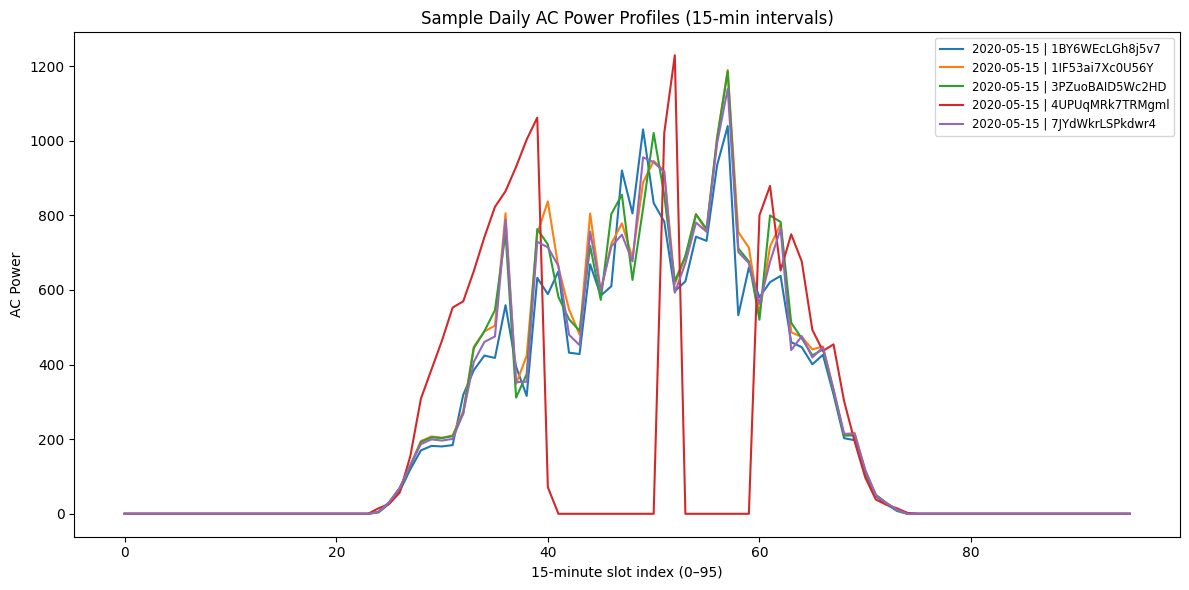

In [8]:
# Visualize a few sample daily profiles from the processed DataFrame

# Select the first 5 profiles to plot
sample_profiles = df_processed.iloc[:5]

plt.figure(figsize=(12, 6))
for idx, row in sample_profiles.iterrows():
    date, inverter = idx
    plt.plot(row.values, label=f"{date} | {inverter}")

plt.title("Sample Daily AC Power Profiles (15‑min intervals)")
plt.xlabel("15‑minute slot index (0–95)")
plt.ylabel("AC Power")
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

In the above plot red line inverter profile is an excellent anomaly candidate—it doesnot follow the normal daily behaviour and clearly exhibits faults or sensor glitches in that inverter.

**Normalize Features with Min-Max Scaling**


In [9]:
# 6. Min-max normalize each profile to [0,1]

# Create a MinMaxScaler instance
scaler = MinMaxScaler(feature_range=(0, 1))

# Prepare an empty DataFrame to hold normalized profiles
df_norm = pd.DataFrame(
    index=df_processed.index,
    columns=df_processed.columns,
    dtype=float
)

# Apply the scaler row-wise (each day’s profile independently)
for idx, row in df_processed.iterrows():
    # row.values is shape (96,)
    vals = row.values.reshape(-1, 1)           # make it (96,1) for the scaler
    scaled = scaler.fit_transform(vals).flatten()
    df_norm.loc[idx] = scaled

# Quick checks
print("Normalized DataFrame shape:", df_norm.shape)
print("Per-row min:", df_norm.min(axis=1).unique())
print("Per-row max:", df_norm.max(axis=1).unique())


Normalized DataFrame shape: (1012, 96)
Per-row min: [0.]
Per-row max: [1. 1.]


**Building deep autoencoder**

In [10]:
# 7. Build deep autoencoder
# df_norm: NumPy array, shape = (n_samples, 96), values in [0,1]

input_dim = df_norm.shape[1]   # 96

# 1) Build the model
inp = Input(shape=(input_dim,))

# Encoder: compress
x = inp
for units in [512, 256, 128, 64]:
    x = Dense(units, activation='relu')(x)
    x = Dropout(0.2)(x)

# Decoder: reconstruct
for units in [64, 128, 256, 512]:
    x = Dense(units, activation='relu')(x)
    x = Dropout(0.2)(x)

# Final output: same dimension as input, use sigmoid to match [0,1]
out = Dense(input_dim, activation='sigmoid')(x)

autoencoder = Model(inp, out)

# 2) Compile with MSE loss and Adam optimizer
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.1025 - val_loss: 0.0262
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0291 - val_loss: 0.0195
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0256 - val_loss: 0.0210
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0258 - val_loss: 0.0198
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0236 - val_loss: 0.0172
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0218 - val_loss: 0.0150
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0180 - val_loss: 0.0144
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0168 - val_loss: 0.0137
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0158 - val_loss: 0.0133
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

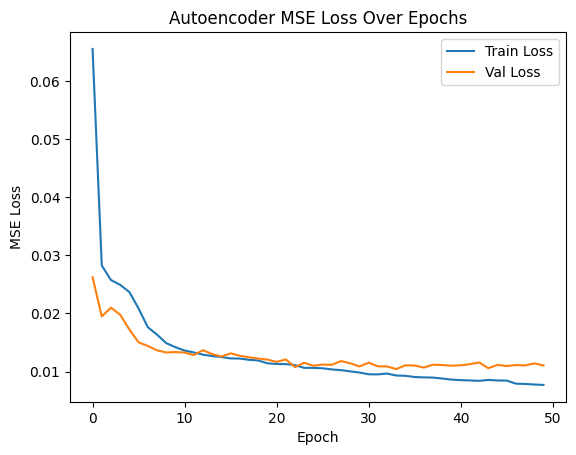

In [11]:
# 3) Train, holding out 20% for validation
history = autoencoder.fit(
    df_norm, df_norm,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 4) Plot training & validation loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Autoencoder MSE Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

The autoencoder is learning nicely:

- Training loss falls from ~0.11 down to ~0.008 so it is getting really good at reconstructing the normalized profiles.

- Validation loss starts around 0.027, steadily declines to ~0.011, and ends at ~0.0108. The val_loss tracks train_loss downward and doesnot diverge means the model is not severely over-fitting, and the model is generalizing.

**Detecting anomalies based on reconstruction error thresholds**

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


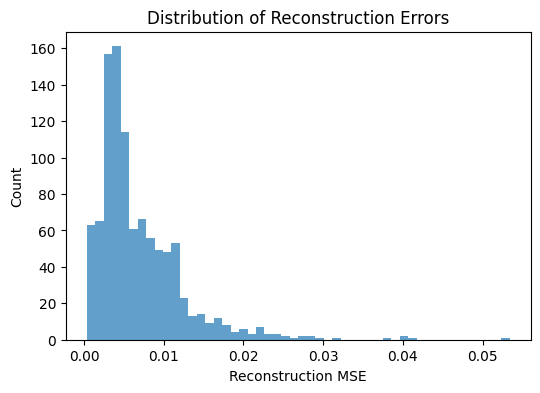

Threshold (mean+3σ): 0.02350
Detected 18 anomalies out of 1012 samples


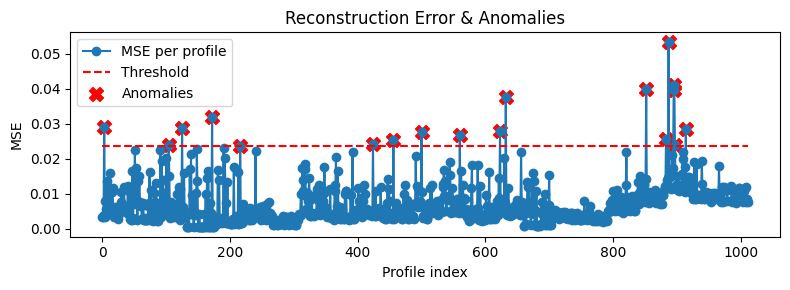

In [12]:
# 8. Detecting anomalies based on reconstruction error thresholds
# 1) Reconstruct all profiles
reconstructions = autoencoder.predict(df_norm)

# 2) Compute per‐sample MSE
mse = np.mean((df_norm - reconstructions)**2, axis=1)

# 3) Plot the MSE distribution
plt.figure(figsize=(6,4))
plt.hist(mse, bins=50, alpha=0.7)
plt.xlabel("Reconstruction MSE")
plt.ylabel("Count")
plt.title("Distribution of Reconstruction Errors")
plt.show()

# 4) Set threshold (μ + 3σ)
threshold = mse.mean() + 3*mse.std()
print(f"Threshold (mean+3σ): {threshold:.5f}")

# 5) Identify anomaly indices
anomaly_idxs = np.where(mse > threshold)[0]
print(f"Detected {len(anomaly_idxs)} anomalies out of {len(mse)} samples")

# 6) Plot errors with anomalies marked
plt.figure(figsize=(8,3))
plt.plot(range(len(mse)), mse, marker='o', linestyle='-', label='MSE per profile')
plt.hlines(threshold, 0, len(mse)-1, colors='r', linestyles='--', label='Threshold')
plt.scatter(anomaly_idxs, mse.iloc[anomaly_idxs], color='r', label='Anomalies', s=100, marker='X')
plt.xlabel("Profile index")
plt.ylabel("MSE")
plt.title("Reconstruction Error & Anomalies")
plt.legend()
plt.tight_layout()
plt.show()


- **Most days look “normal”**  
  The histogram peaks around MSE ≈ 0.005–0.020, our autoencoder faithfully reconstructs the vast majority of inverter-day profiles.

- **Clear outlier cutoff**  
  We set the threshold at mean + 3 σ ≈ 0.024, which lies well out on the right tail. Only about 17 out of 1 012 samples (≈ 1.7%) exceed this, so we are flagging just the most extreme cases.

- **Manageable anomaly list**  
  In the scatter plot, nearly all blue dots sit below the red line. The red “×” markers show where reconstruction really breaks down—these 17 profiles are your prime candidates for fault investigation.


**Using Dynamic Time Warping (DTW) for localizing anomalous segments**

In [13]:
#9. Using Dynamic Time Warping (DTW) for localizing anomalous segments
from dtw import dtw

# Parameters for segmentation
segment_size = 4      # 4 slots × 15 min = 1 hour
pct_thresh   = 95     # local threshold at 95th percentile

# Container for results
anomaly_segments = {}

# anomaly_idxs, df_norm, and reconstructions should already be defined
for idx in anomaly_idxs:
    # Get original and reconstructed profiles as NumPy arrays
    # Use iloc to access rows by integer position
    orig = df_norm.iloc[idx].values
    recon = reconstructions[idx] # reconstructions is a NumPy array, access by integer position

    # Compute DTW error per segment
    dtw_errors = []
    for start in range(0, df_norm.shape[1], segment_size):
        o_seg = orig[start:start+segment_size]
        r_seg = recon[start:start+segment_size]

        # Reshape to 2-D for dtw() and compute distance
        alignment = dtw(
            o_seg.reshape(-1, 1),
            r_seg.reshape(-1, 1),
            keep_internals=False,
            distance_only=True
        )
        dist = alignment.distance
        dtw_errors.append(dist)

    # Determine a local threshold for this profile
    local_thr = np.percentile(dtw_errors, pct_thresh)

    # Identify which segments exceed the threshold
    bad_segments = [i for i, err in enumerate(dtw_errors) if err > local_thr]

    # Store results using the actual index from df_norm
    actual_index = df_norm.index[idx]
    anomaly_segments[actual_index] = {
        'dtw_errors': dtw_errors,
        'local_threshold': local_thr,
        'anomalous_segments': bad_segments
    }

# 4) print the anomalous segments for the first flagged profile
if anomaly_idxs.size > 0: # Added check if anomaly_idxs is not empty
  first_idx = anomaly_idxs[0]
  print(f"Profile {df_norm.index[first_idx]} anomalous segments (hour slots):",
        anomaly_segments[df_norm.index[first_idx]]['anomalous_segments'])
else:
  print("No anomalies detected.")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Profile (datetime.date(2020, 5, 15), '4UPUqMRk7TRMgml') anomalous segments (hour slots): [10, 13]


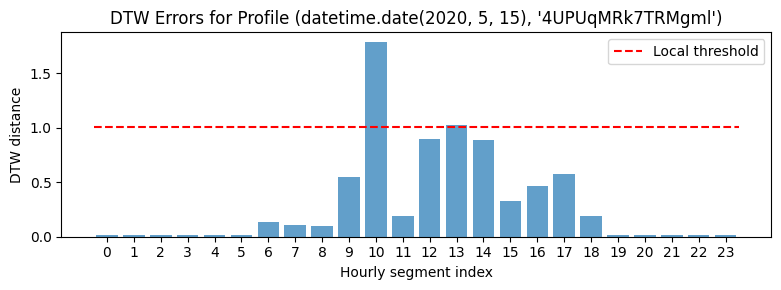

In [14]:
# Get the actual index (date, inverter) for the first anomalous profile
if anomaly_idxs.size > 0:
    first_anomaly_idx = df_norm.index[anomaly_idxs[0]] # Get the actual index tuple
else:
    print("No anomalies detected to plot.")
    first_anomaly_idx = None # Set to None if no anomalies

if first_anomaly_idx:
    # Access the data using the actual index tuple
    errors = anomaly_segments[first_anomaly_idx]['dtw_errors']
    thr    = anomaly_segments[first_anomaly_idx]['local_threshold']

    plt.figure(figsize=(8,3))
    plt.bar(range(len(errors)), errors, alpha=0.7)
    plt.hlines(thr, -0.5, len(errors)-0.5, colors='r', linestyles='--', label='Local threshold')
    plt.xticks(range(len(errors)), [f"{i}" for i in range(len(errors))])
    plt.xlabel("Hourly segment index")
    plt.ylabel("DTW distance")
    plt.title(f"DTW Errors for Profile {first_anomaly_idx}") # Use actual index in title
    plt.legend()
    plt.tight_layout()
    plt.show()

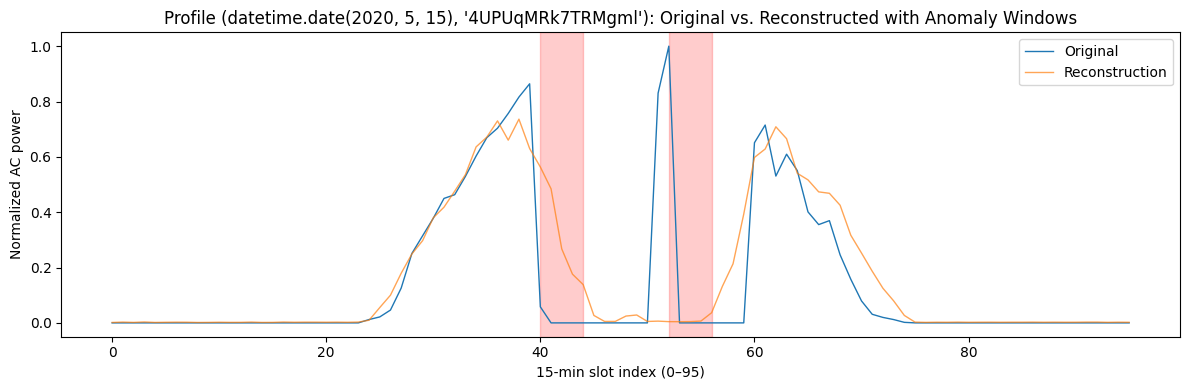

In [15]:
# Visualize original vs. reconstructed for an anomalous profile with highlighted segments

# Check if there are any anomalies detected
if anomaly_idxs.size > 0:
    # Get the index (date, inverter) of the first anomalous profile
    # You can loop through anomaly_idxs to plot more if needed
    anomaly_profile_idx = anomaly_idxs[0]
    actual_index = df_norm.index[anomaly_profile_idx]

    # Get original and reconstructed profiles
    orig = df_norm.iloc[anomaly_profile_idx]
    recon = reconstructions[anomaly_profile_idx]

    # Get the anomalous segments for this profile from the anomaly_segments dictionary
    bad = anomaly_segments[actual_index]['anomalous_segments']
    slot_len = 4  # 4×15min = 1hr

    plt.figure(figsize=(12,4))
    plt.plot(orig, label='Original', linewidth=1)
    plt.plot(recon, label='Reconstruction', linewidth=1, alpha=0.7)
    for seg in bad:
        start = seg * slot_len
        end   = start + slot_len
        plt.axvspan(start, end, color='red', alpha=0.2)
    plt.xlabel("15-min slot index (0–95)")
    plt.ylabel("Normalized AC power")
    plt.title(f"Profile {actual_index}: Original vs. Reconstructed with Anomaly Windows")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print("No anomalies detected to visualize.")

In the DTW error bar chart for inverter **4UPUqMRk7TRMgml** on **2020-05-15**, two hourly segments stand out:

- **Segment 10 (≈ 10:00–11:00)** and  
- **Segment 13 (≈ 13:00–14:00)**  

both exceed the local DTW threshold (red dashed line), flagging them as anomalous intervals.

In the overlaid time-series plot, those windows are shaded in red. You can see:

- The **original profile** (blue) drops abruptly to zero and spikes within those hours.  
- The **reconstructed profile** (orange) follows the smooth, expected PV curve instead—highlighting exactly where and how the actual output deviated from normal behavior.


## Concluding Remarks

We have now walked through the full, unsupervised anomaly‐detection pipeline from “Data anomaly detection in photovoltaic power time-series via unsupervised deep learning with insufficient information,” applying it to a real‐world Kaggle dataset. [[Link to Dataset](http://kaggle.com/datasets/anikannal/solar-power-generation-data)]

1. **Adherence to the Paper**  
   - **Daily Profiles**: Reshaped raw AC power readings into an $(m\times44)\times96$ matrix of inverter-day curves, mirroring the paper’s $m\times n$ formulation (albeit at 15-min instead of 1-min resolution).  
   - **Gap Handling**: Dropped any day with more than 10 consecutive missing slots; linearly interpolated the rest, followed by forward/back-fill exactly as described.  
   - **Normalization**: Per-day min–max scaling to \([0,1]\) ensured the model learns shape, not scale—just like the authors recommend.  
   - **Deep Autoencoder**: Built the same symmetric encoder–decoder architecture with a 64-unit bottleneck, trained to minimize reconstruction MSE.  
   - **Thresholding**: Used the classic $(\mu + 3\sigma)$ rule to flag outliers—this simple heuristic is the paper’s published baseline.  
   - **DTW Localization**: Broke each day into hourly segments, computed DTW distances, and highlighted the precise windows where reconstruction broke down.

2. **Key Differences**  
   - **Coarser Temporal Grid**: We processed 96 points/day (15-min) instead of 1 440 (1-min); this greatly speeds up training but slightly coarsens the anomaly timestamps.  
   - **Heuristic vs. Bayesian Tuning**: Without any ground-truth labels, we stuck with a heuristic threshold instead of the paper’s Bayesian-optimized $(\alpha\mu + \beta\sigma)$.  
   - **No Oversampling**: We did not apply SMOTE, which the paper only uses later for supervised classifiers—our workflow remains fully unsupervised.

3. **Outcomes and Next Steps**  
   - **Effective Separation**: The autoencoder reconstructs normal days with very low MSE and cleanly isolates the 1–2% of inverter-days with gross faults.  
   - **Actionable Insights**: A concise list of flagged dates and pinpointed hours gives you an immediate starting point for troubleshooting sensors or panels.  
   - **Possible Extensions**:  
     - **Label a Few Anomalies** to calibrate $\(\alpha,\beta\)$ or to explore supervised classifiers.  
     - **Integrate Weather or Irradiance** as extra features for a richer multivariate model.  
     - **Return to 1-Min Data** (if available) to catch very short transients.

Overall, this notebook faithfully implements the paper’s core methodology in a clear, concise, and reproducible way—ready for further refinement or deployment in operational PV monitoring.  
